## The Culture of International Relations - Text Analysis
### <span style='color: green'>SETUP </span> Prepare and Setup Notebook <span style='float: right; color: red'>MANDATORY</span>

In [1]:
# Setup
%load_ext autoreload
%autoreload 2

import sys, os, collections, zipfile
import re, typing.re

sys.path = list(set(['.', '..']) - set(sys.path)) + sys.path

import nltk, textacy, spacy 
import pandas as pd
import ipywidgets as widgets
import bokeh, bokeh.plotting, bokeh.models, matplotlib.pyplot as plt
import common.utility as utility
import common.widgets_utility as widgets_utility
import common.widgets_config as widgets_config
import common.config as config
import common.utility as utility
import common.treaty_utility as treaty_utility
import common.treaty_state as treaty_repository
import treaty_corpus
import types, glob
import textacy.keyterms
import qgrid

from beakerx.object import beakerx
from beakerx import *
from IPython.display import display, set_matplotlib_formats

logger = utility.getLogger('corpus_text_analysis')

import pickle
import topic_model
import topic_model_utility

pd.options.display.max_columns = None
pd.options.display.max_rows = None
#pd.options.display.max_colwidth = -1
pd.options.display.colheader_justify = 'left'
#pd.options.display.precision = 4

DATA_FOLDER = '../data'
PATTERN = '*.txt'
PERIOD_GROUP = 'years_1945-1972'
DF_TAGSET = pd.read_csv('../data/tagset.csv', sep='\t').fillna('')

FIXED_STOPWORDS = ['', '\n', 'et', 'al', 'et.al.' ]
WTI_INDEX = treaty_repository.load_wti_index(data_folder=DATA_FOLDER)

%matplotlib inline
# set_matplotlib_formats('svg')   
bokeh.plotting.output_notebook()

def trunc_year_by(series, divisor):
    return (series - series.mod(divisor)).astype(int) 

TREATY_TIME_GROUPINGS = {
    'treaty_id': { 'column': 'treaty_id', 'divisor': None, 'title': 'Treaty', 'fx': None},
    'signed_year': { 'column': 'signed_year', 'divisor': 1, 'title': 'Year', 'fx': None },
    'signed_lustrum': { 'column': 'signed_lustrum', 'divisor': 5, 'title': 'Lustrum', 'fx': lambda df: trunc_year_by(df.signed_year, 5) },
    'signed_decade': { 'column': 'signed_decade', 'divisor': 10, 'title': 'Decade', 'fx': lambda df: trunc_year_by(df.signed_year, 10) }
}

class TopicModelNotComputed(Exception):
    @staticmethod
    def check():
        if 'TM_GUI_MODEL' in globals():
            gui =  globals()['TM_GUI_MODEL']
            if None not in (gui, gui.model):
                return True
        msg = 'A topic model must be computed using step "MODEL Compute a Topic Model"'
        raise TopicModelNotComputed(msg)
        
class CorpusNotLoaded(Exception):
    pass

def get_current_model():
    TopicModelNotComputed.check()
    return globals()['TM_GUI_MODEL'].model

def get_current_corpus():
    if 'CURRENT_CORPUS' in globals():
        if globals()['CURRENT_CORPUS'].textacy_corpus is not None:
            return globals()['CURRENT_CORPUS']
    raise CorpusNotLoaded('Corpus not loaded or computed')


2018-12-16 07:26:05,212 : INFO : 'pattern' package not found; tag filters are not available for English
2018-12-16 07:26:05,717 : INFO : WTI index loaded!


Loading BokehJS ...

## <span style='color: green'>PREPARE </span> Load and Prepare Corpus <span style='float: right; color: red'>MANDATORY</span>


In [2]:
import textacy_corpus_utility as textacy_utility
import textacy_corpus_gui

if 'CURRENT_CORPUS' not in globals():
    CURRENT_CORPUS = types.SimpleNamespace(
        language=None,
        source_path=None,
        prepped_source_path=None,
        textacy_corpus_path=None,
        textacy_corpus=None,
        nlp=None
    )

try:
    textacy_corpus_gui.display_corpus_load_gui(DATA_FOLDER, WTI_INDEX, CURRENT_CORPUS)
except Exception as ex:
    logger.error(ex)


In [ ]:
import gensim
vec_args = dict(apply_idf=False)
term_args = dict(
    args=dict(
        ngrams=2,
        named_entities=False,
        normalize='lemma',
        as_strings=True
    ),
    kwargs=dict(
        filter_nums=False,
        drop_determiners=False,
        min_freq=2,
        include_pos=[ 'NOUN', 'PROPN' ],
        filter_stops=False,
        filter_punct=True
    ),
    extra_stop_words=[]
)

tm_args = dict(n_topics=10, max_iter=600, learning_method='online', n_jobs=1)
# gui.model = topic_model.compute(corpus=corpus, tick=utility.noop, method='gensim_lda', vec_args=vec_args, term_args=term_args, tm_args=tm_args )

def terms_iter(corpus, term_args=None):
    
    n_gram_size = term_args.get('args', {}).get('ngrams', 1)

    fx_doc_iter = lambda: ( textacy_utility.textacy_filter_terms(doc, term_args) for doc in corpus )
    
    doc_iter = ( doc for doc in fx_doc_iter() )
    
    if n_gram_size in (2, 3):
        bigram = gensim.models.Phrases(fx_doc_iter())
        bigram_model = gensim.models.phrases.Phraser(bigram)
        #if n_gram_size == 3:
        # trigram = gensim.models.Phrases(bigram[fx_doc_iter()], threshold=100) 
        #    trigram = gensim.models.Phrases(bigram[fx_doc_iter()], threshold=100)
        doc_iter = bigram_model[fx_doc_iter()]

    return doc_iter

corpus = get_current_corpus().textacy_corpus

list([ x for x in terms_iter(corpus, term_args) ][1])
    


## <span style='color: green'>PREPARE/DESCRIBE </span> Find Key Terms <span style='float: right; color: green'>OPTIONAL</span>
- [TextRank]	Mihalcea, R., & Tarau, P. (2004, July). TextRank: Bringing order into texts. Association for Computational Linguistics.
- [SingleRank]	Hasan, K. S., & Ng, V. (2010, August). Conundrums in unsupervised keyphrase extraction: making sense of the state-of-the-art. In Proceedings of the 23rd International Conference on Computational Linguistics: Posters (pp. 365-373). Association for Computational Linguistics.
- [RAKE]	Rose, S., Engel, D., Cramer, N., & Cowley, W. (2010). Automatic Keyword Extraction from Individual Documents. In M. W. Berry & J. Kogan (Eds.), Text Mining: Theory and Applications: John Wiley & Son
https://github.com/csurfer/rake-nltk
https://github.com/aneesha/RAKE
https://github.com/vgrabovets/multi_rake



#### <span style='color: green'>PREPARE/DESCRIBE </span>RAKE <span style='float: right; color: green'>WORK IN PROGRESS</span>

https://github.com/JRC1995/RAKE-Keyword-Extraction
https://github.com/JRC1995/TextRank-Keyword-Extraction

In [198]:
# Document Key Terms
from rake_nltk import Rake, Metric
import string
import textacy_corpus_utility as textacy_utility
import gui_utility

def textacy_rake(doc, language='english', normalize='lemma', n_keyterms=20, stopwords=None, metric=Metric.DEGREE_TO_FREQUENCY_RATIO):
    punctuations = string.punctuation + "\""
    r = Rake(
        stopwords=stopwords,  # NLTK stopwords if None
        punctuations=punctuations, # NLTK by default
        language=language,
        ranking_metric=metric,
        max_length=100000,
        min_length=1
    )
    text = ' '.join([ x.lemma_ for x in doc.spacy_doc ] if normalize == 'lemma' else [ x.lower_ for x in doc.spacy_doc ])
    r.extract_keywords_from_text(doc.text)
    keyterms = [ (y, x) for (x, y) in r.get_ranked_phrases_with_scores() ]
    return keyterms[:n_keyterms]


def display_rake_gui(corpus, language):
    
    document_options = gui_utility.get_treaty_dropdown_options(WTI_INDEX, corpus)
    metric_options = [
        ('Degree / Frequency', Metric.DEGREE_TO_FREQUENCY_RATIO),
        ('Degree', Metric.WORD_DEGREE),
        ('Frequency', Metric.WORD_FREQUENCY)
    ]
    gui = types.SimpleNamespace(
        progress=widgets.IntProgress(min=0, max=1, step=1, layout=widgets.Layout(width='95%')),
        output=widgets.Output(layout={'border': '1px solid black'}),
        n_keyterms=widgets.IntSlider(description='#words', min=10, max=500, value=10, step=1, layout=widgets.Layout(width='340px')),
        document_id=widgets.Dropdown(description='Treaty', options=document_options, value=document_options[1][1], layout=widgets.Layout(width='40%')),
        metric=widgets.Dropdown(description='Metric', options=metric_options, value=Metric.DEGREE_TO_FREQUENCY_RATIO, layout=widgets.Layout(width='300px')),
        normalize=widgets.Dropdown(description='Normalize', options=[ 'lemma', 'lower' ], value='lemma', layout=widgets.Layout(width='160px'))
    )
    
    def compute_textacy_rake(corpus, treaty_id, language, normalize, n_keyterms, metric):
        gui.output.clear_output()
        with gui.output:
            doc = textacy_utility.get_treaty_doc(corpus, treaty_id)
            phrases = textacy_rake(doc, language=language, normalize=normalize, n_keyterms=n_keyterms, stopwords=None, metric=metric)
            df = pd.DataFrame(phrases, columns=['phrase', 'score'])
            display(df.set_index('phrase'))
            return df
    
    itw = widgets.interactive(
        compute_textacy_rake,
        corpus=widgets.fixed(corpus),
        treaty_id=gui.document_id,
        language=widgets.fixed(language),
        normalize=gui.normalize,
        n_keyterms=gui.n_keyterms,
        metric=gui.metric
    )

    display(widgets.VBox([
        gui.progress,
        widgets.HBox([gui.document_id, gui.metric, gui.normalize]),
        widgets.HBox([gui.n_keyterms]),
        gui.output
    ]))

    itw.update()

try:
    corpus = get_current_corpus().textacy_corpus
    display_rake_gui(corpus, language='english')
except Exception as ex:
    logger.error(ex)


#### <span style='color: green'>PREPARE/DESCRIBE </span>TextRank/SingleRank <span style='float: right; color: green'>OPTIONAL</span>

https://github.com/JRC1995/TextRank-Keyword-Extraction
  

In [5]:
import gui_utility
import textacy_corpus_utility as textacy_utility

def display_document_key_terms_gui(corpus, wti_index):
    
    methods = { 'RAKE': textacy_rake, 'SingleRank': textacy.keyterms.singlerank, 'TextRank': textacy.keyterms.textrank }
    document_options = [('All Treaties', None)] + gui_utility.get_treaty_dropdown_options(wti_index, corpus)
    
    gui = types.SimpleNamespace(
        progress=widgets.IntProgress(min=0, max=1, step=1, layout=widgets.Layout(width='95%')),
        output=widgets.Output(layout={'border': '1px solid black'}),
        n_keyterms=widgets.IntSlider(description='#words', min=10, max=500, value=100, step=1, layout=widgets.Layout(width='240px')),
        document_id=widgets.Dropdown(description='Treaty', options=document_options, value=document_options[1][1], layout=widgets.Layout(width='40%')),
        method=widgets.Dropdown(description='Algorithm', options=[ 'RAKE', 'TextRank', 'SingleRank' ], value='TextRank', layout=widgets.Layout(width='180px')),
        normalize=widgets.Dropdown(description='Normalize', options=[ 'lemma', 'lower' ], value='lemma', layout=widgets.Layout(width='160px'))
    )
    
    def get_keyterms(method, doc, normalize, n_keyterms):
        keyterms = methods[method](doc, normalize=normalize, n_keyterms=n_keyterms)
        terms = ', '.join([ x for x, y in keyterms ])
        gui.progress.value += 1
        return terms
    
    def get_document_key_terms(corpus, method='TextRank', document_id=None, normalize='lemma', n_keyterms=10):
        treaty_ids = [ document_id ] if document_id is not None else [ doc.metadata['treaty_id'] for doc in corpus ]
        gui.progress.value = 0
        gui.progress.max = len(treaty_ids)
        keyterms = [
            get_keyterms(method, textacy_utility.get_treaty_doc(corpus, treaty_id), normalize, n_keyterms) for treaty_id in treaty_ids
        ]
        df = pd.DataFrame({ 'treaty_id': treaty_ids, 'keyterms': keyterms}).set_index('treaty_id')
        gui.progress.value = 0
        return df

    def display_document_key_terms(corpus, method='TextRank', document_id=None, normalize='lemma', n_keyterms=10):
        gui.output.clear_output()
        with gui.output:
            df = get_document_key_terms(corpus, method, document_id, normalize, n_keyterms)
            #qgrid_widget = qgrid.show_grid(df, show_toolbar=False)
            #display(qgrid_widget)
            table = TableDisplay(df)
            display(table)
            
    itw = widgets.interactive(
        display_document_key_terms,
        corpus=widgets.fixed(corpus),
        method=gui.method,
        document_id=gui.document_id,
        normalize=gui.normalize,
        n_keyterms=gui.n_keyterms,
    )

    display(widgets.VBox([
        gui.progress,
        widgets.HBox([gui.document_id, gui.method, gui.normalize, gui.n_keyterms]),
        gui.output
    ]))

    itw.update()

display_document_key_terms_gui(CURRENT_CORPUS.textacy_corpus, WTI_INDEX)



## <span style='color: green'>PREPARE/DESCRIBE </span> Clean Up the Text <span style='float: right; color: green'>TRY IT</span>

In [7]:
import gui_utility
import textacy_corpus_utility as textacy_utility

%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

def plot_xy_data(data, title='', xlabel='', ylabel='', **kwargs):
    x, y = list(data[0]), list(data[1])
    labels = x
    plt.figure(figsize=(8, 9 / 1.618))
    plt.plot(x, y, 'ro', **kwargs)
    plt.xticks(x, labels, rotation='75')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def display_cleaned_up_text(container, gui, display_type, treaty_id, **kwargs): # ngrams, named_entities, normalize, include_pos):
    
    corpus = container.textacy_corpus
    
    gui.output_text.clear_output()
    gui.output_statistics.clear_output()
    
    doc = textacy_utility.get_treaty_doc(corpus, treaty_id)
    
    if doc is None:
        return
    
    terms = [ x for x in doc.to_terms_list(as_strings=True, **kwargs) ]
    
    if display_type.startswith('source_text'):
        
        source_files = {
            'source_text_raw': { 'filename': container.source_path, 'description': 'Raw text from PDF: Automatic text extraction using pdfminer Python package. ' },
            'source_text_edited': { 'filename': container.source_path, 'description': 'Manually edited text: List of references, index, notes and page headers etc. removed.' },
            'source_text_preprocessed': { 'filename': container.prepped_source_path, 'description': 'Preprocessed text: Normalized whitespaces. Unicode fixes. Urls, emails and phonenumbers removed. Accents removed.' }
        }        
        
        source_filename = source_files[display_type]['filename']
        description =  source_files[display_type]['description']
        text = utility.zip_get_text(source_filename, doc.metadata['filename'])
        
        with gui.output_text:
            #print('{}\n.................\n(NOT SHOWN TEXT)\n.................\n{}'.format(document[:2500], document[-250:]))
            #print(doc)
            print('[ ' + description.upper() + ' ]')
            print(text)
        return

    if len(terms) == 0:
        with gui.output_text:
            print("No text. Please change selection.")
        return
    
    if display_type in ['sanitized_text', 'statistics']:

        if display_type == 'sanitized_text':
            with gui.output_text:
                #display('{}\n.................\n(NOT SHOWN TEXT)\n.................\n{}'.format(
                #    ' '.join(tokens[:word_count]),
                #    ' '.join(tokens[-word_count:])
                #))
                print(' '.join([ t.replace(' ', '_') for t in terms ]))
                return

        if display_type == 'statistics':

            wf = nltk.FreqDist(terms)

            with gui.output_text:

                df = pd.DataFrame(wf.most_common(25), columns=['token','count'])
                print('Token count: {} Vocab count: {}'.format(wf.N(), wf.B()))
                display(df)
 
            with gui.output_statistics:

                data = list(zip(*wf.most_common(25)))
                plot_xy_data(data, title='Word distribution', xlabel='Word', ylabel='Word count')

                wf = nltk.FreqDist([len(x) for x in terms])
                data = list(zip(*wf.most_common(25)))
                plot_xy_data(data, title='Word length distribution', xlabel='Word length', ylabel='Word count')

def display_cleanup_text_gui(container, wti_index):
    
    corpus = container.textacy_corpus
    document_options = [('All Treaties', None)] + gui_utility.get_treaty_dropdown_options(wti_index, corpus)
    
    #pos_options = [ x for x in DF_TAGSET.POS.unique() if x not in ['PUNCT', '', 'DET', 'X', 'SPACE', 'PART', 'CONJ', 'SYM', 'INTJ', 'PRON']]  # groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x)).to_dict()
    pos_tags = DF_TAGSET.groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x[:1])).to_dict()
    pos_options = [('(All)', None)] + sorted([(k + ' (' + v + ')', k) for k,v in pos_tags.items() ])
    display_options = {
        'Source text (raw)': 'source_text_raw',
        'Source text (edited)': 'source_text_edited',
        'Source text (processed)': 'source_text_preprocessed',
        'Sanitized text': 'sanitized_text',
        'Statistics': 'statistics'
    }
    ngrams_options = { '1': [1], '1,2': [1,2], '1,2,3': [1,2,3]}
    gui = types.SimpleNamespace(
        treaty_id=widgets.Dropdown(description='Treaty', options=document_options, value=None, layout=widgets.Layout(width='400px')),
        progress=widgets.IntProgress(value=0, min=0, max=5, step=1, description='', layout=widgets.Layout(width='90%')),
        min_freq=widgets.FloatSlider(value=0, min=0, max=1.0, step=0.01, description='Min frequency', layout=widgets.Layout(width='400px')),
        ngrams=widgets.Dropdown(description='n-grams', options=ngrams_options, value=[1], layout=widgets.Layout(width='180px')),
        min_word=widgets.Dropdown(description='Min length', options=[1,2,3,4], value=1, layout=widgets.Layout(width='180px')),
        normalize=widgets.Dropdown(description='Normalize', options=[ False, 'lemma', 'lower' ], value=False, layout=widgets.Layout(width='180px')),
        filter_stops=widgets.ToggleButton(value=False, description='Filter stops',  tooltip='Filter out stopwords', icon='check'),
        filter_nums=widgets.ToggleButton(value=False, description='Filter nums',  tooltip='Filter out stopwords', icon='check'),
        filter_punct=widgets.ToggleButton(value=False, description='Filter punct',  tooltip='Filter out punctuations', icon='check'),
        named_entities=widgets.ToggleButton(value=False, description='Merge entities',  tooltip='Merge entities', icon='check'),
        drop_determiners=widgets.ToggleButton(value=False, description='Drop determiners',  tooltip='Drop determiners', icon='check'),
        include_pos=widgets.SelectMultiple(description='POS', options=pos_options, value=list(), rows=10, layout=widgets.Layout(width='400px')),
        display_type=widgets.Dropdown(description='Show', value='statistics', options=display_options, layout=widgets.Layout(width='180px')),
        output_text=widgets.Output(layout={'height': '500px'}),
        output_statistics = widgets.Output(),
        boxes=None
    )
    
    uix = widgets.interactive(

        display_cleaned_up_text,

        container=widgets.fixed(container),
        gui=widgets.fixed(gui),
        display_type=gui.display_type,
        treaty_id=gui.treaty_id,
        
        ngrams=gui.ngrams,
        named_entities=gui.named_entities,
        normalize=gui.normalize,
        filter_stops=gui.filter_stops,
        filter_punct=gui.filter_punct,
        filter_nums=gui.filter_nums,
        include_pos=gui.include_pos,
        min_freq=gui.min_freq,
        drop_determiners=gui.drop_determiners
    )
    
    gui.boxes = widgets.VBox([
        gui.progress,
        widgets.HBox([
            widgets.VBox([
                gui.treaty_id,
                widgets.HBox([gui.display_type, gui.normalize]),
                widgets.HBox([gui.ngrams, gui.min_word]),
                gui.min_freq
            ]),
            widgets.VBox([
                gui.include_pos
            ]),
            widgets.VBox([
                gui.filter_stops,
                gui.filter_nums,
                gui.filter_punct,
                gui.named_entities,
                gui.drop_determiners
            ])
        ]),
        widgets.HBox([
            gui.output_text, gui.output_statistics
        ]),
        uix.children[-1]
    ])
    
    display(gui.boxes)
                                  
    uix.update()
    return gui, uix

try:
    xgui, xuix = display_cleanup_text_gui(get_current_corpus(), WTI_INDEX)
except Exception as ex:
    logger.error(ex)


### <span style='color: green;'>DESCRIBE</span> Most Discriminating Terms<span style='color: blue; float: right'>OPTIONAL</span>
References
King, Gary, Patrick Lam, and Margaret Roberts. “Computer-Assisted Keyword and Document Set Discovery from Unstructured Text.” (2014). http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.1445&rep=rep1&type=pdf


In [127]:

import spacy

def compute_most_discriminating_terms(
    wti_index,
    corpus,
    gui,
    group1=None,
    group2=None,
    top_n_terms=25,
    max_n_terms=1000,
    include_pos=None,
    period1=None,
    period2=None,
    closed_region=False,
    normalize=spacy.attrs.LEMMA
):
    def get_token_attr(token, feature):
        if feature == spacy.attrs.LEMMA:
            return token.lemma_
        if feature == spacy.attrs.LOWER:
            return token.lower_
        return token.orth_
    
    def get_term_list(corpus, region=None, period=None, closed_region=False):
        
        region = set(region or [])
        docs = ( x for x in corpus )
        
        if len(region) > 0:
            if closed_region:
                docs = ( x for x in docs if (x.metadata['party1'] in region or x.metadata['party2'] in region) )
            else:
                docs = ( x for x in docs if (x.metadata['party1'] in region and x.metadata['party2'] in region) )

        if period is not None:
            docs = (x for x in docs if (period[0] <= x.metadata['signed_year']) and (x.metadata['signed_year'] <= period[1]))
        
        return [[ get_token_attr(x, normalize) for x in doc if x.pos_ in include_pos and len(x) > 1 ] for doc in docs]
        
    docs1 = get_term_list(corpus, group1, period1, closed_region)
    docs2 = get_term_list(corpus, group2, period2, closed_region)
    
    docs = docs1 + docs2
    
    in_group1 = [True] * len(docs1) + [False] * len(docs2)   
    
    terms = textacy.keyterms.most_discriminating_terms(docs, in_group1, top_n_terms=top_n_terms, max_n_terms=max_n_terms)
    min_terms = min(len(terms[0]), len(terms[1]))
    df = pd.DataFrame({'Group 1': terms[0][:min_terms], 'Group 2': terms[1][:min_terms] })
    
    return df
    
def display_most_discriminating_terms(gui, df):
    display(df)
        
def most_discriminating_terms_gui(wti_index, corpus, compute_callback, display_callback):
    
    lw = lambda w: widgets.Layout(width=w)   
    
    include_pos_tags = [ 'ADJ', 'VERB', 'NUM', 'ADV', 'NOUN', 'PROPN' ]
    normalize_options = { 'Lemma': spacy.attrs.LEMMA, 'Lower': spacy.attrs.LOWER, 'Orth': spacy.attrs.ORTH }
    party_preset_options = wti_index.get_party_preset_options()
    parties_options = [ x for x in wti_index.get_countries_list() if x != 'ALL OTHER' ]
    
    signed_years = { d.metadata['signed_year'] for d in corpus }
    period_default = (min(signed_years), max(signed_years))

    gui = types.SimpleNamespace(
        progress=widgets.IntProgress(value=0, min=0, max=5, step=1, description='', layout=lw('90%')),
        group1=widgets.SelectMultiple(description='Group 1', options=parties_options, value=[], rows=7, layout=lw('250px')),
        group2=widgets.SelectMultiple(description='Group 2', options=parties_options, value=[], rows=7, layout=lw('250px')),
        group1_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('250px')),
        group2_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('250px')),
        top_n_terms=widgets.IntSlider(description='#terms', min=10, max=1000, value=100, tooltip='The total number of most discriminating terms to return for each group'),
        max_n_terms=widgets.IntSlider(description='#top', min=1, max=2000, value=2000, tooltip='Only consider terms whose document frequency is within the top # terms out of all terms'),
        include_pos=widgets.SelectMultiple(description='POS', options=include_pos_tags, value=include_pos_tags, rows=7, layout=lw('150px')),
        period1=widgets.IntRangeSlider(description='Period', min=period_default[0], max=period_default[1], value=period_default, layout=lw('250px')),
        period2=widgets.IntRangeSlider(description='Period', min=period_default[0], max=period_default[1], value=period_default, layout=lw('250px')),
        closed_region=widgets.ToggleButton(description='Closed regions', icon='check', value=True, disabled=False, layout=lw('140px')),
        sync_period=widgets.ToggleButton(description='Sync period', icon='check', value=False, disabled=False, layout=lw('140px'), tooltop='HEJ'),
        normalize=widgets.Dropdown(description='Normalize', options=normalize_options, value=spacy.attrs.LEMMA, layout=lw('200px')),
        compute=widgets.Button(description='Compute', icon='', button_style='Success', layout=lw('120px')),
        output=widgets.Output(layout={'border': '1px solid black'})
    )
    
    boxes = widgets.VBox([
        widgets.HBox([
            widgets.VBox([
                gui.group1,
                gui.group1_preset,
                gui.period1
            ]),
            widgets.VBox([
                gui.group2,
                gui.group2_preset,
                gui.period2
            ]),
            widgets.VBox([
                gui.include_pos,
                gui.closed_region,
                gui.sync_period,
            ], layout=widgets.Layout(align_items='flex-end')),
            widgets.VBox([
                gui.top_n_terms,
                gui.max_n_terms,
                gui.normalize
            ]), # layout=widgets.Layout(align_items='flex-end')),
            widgets.VBox([
                gui.compute,
                widgets.HTML(
                    '<b>#terms</b> is the  number of most discriminating<br>terms to return for each group.<br>' +
                    '<b>#top</b> Consider only terms with a frequency<br>within the top #top terms out of all terms<br>'
                    '<b>Closed region</b> If checked, then <u>both</u> treaty parties<br>must be within selected region'
                )
            ])
        ]),
        gui.output
    ])
    
    display(boxes)
    
    def on_group1_preset_change(change):
        if gui.group1_preset.value is None:
            return
        gui.group1.value = gui.group1.options if 'ALL' in gui.group1_preset.value else gui.group1_preset.value   
    
    def on_group2_preset_change(change):
        if gui.group2_preset.value is None:
            return
        gui.group2.value = gui.group2.options if 'ALL' in gui.group2_preset.value else gui.group2_preset.value
        
    def on_period1_change(change):
        if gui.sync_period.value:
            gui.period2.value = gui.period1.value
            
    def on_period2_change(change):
        if gui.sync_period.value:
            gui.period1.value = gui.period2.value
            
    gui.group1_preset.observe(on_group1_preset_change, names='value') 
    gui.group2_preset.observe(on_group2_preset_change, names='value')
    
    gui.period1.observe(on_period1_change, names='value')
    gui.period2.observe(on_period2_change, names='value')
    
    def compute_callback_handler(*_args):
        gui.output.clear_output()
        with gui.output:
            try:
                gui.compute.disabled = True
                df = compute_callback(
                    wti_index=wti_index,
                    corpus=corpus,
                    gui=gui,
                    group1=gui.group1.value,
                    group2=gui.group2.value,
                    top_n_terms=gui.top_n_terms.value,
                    max_n_terms=gui.max_n_terms.value,
                    include_pos=gui.include_pos.value,
                    period1=gui.period1.value,
                    period2=gui.period2.value,
                    closed_region=gui.closed_region.value,
                    normalize=gui.normalize.value
                )
                display_callback(gui, df)
            finally:
                gui.compute.disabled = False
                
    gui.compute.on_click(compute_callback_handler)
    return gui
                
try:
    most_discriminating_terms_gui(
        WTI_INDEX,
        get_current_corpus().textacy_corpus,
        compute_callback=compute_most_discriminating_terms,
        display_callback=display_most_discriminating_terms
    )
except Exception as ex:
    raise
    logger.error(ex)

## <span style='color: green;'>DESCRIBE</span> Corpus Statistics<span style='color: blue; float: right'>OPTIONAL</span>

### <span style='color: green;'>DESCRIBE</span> List of Most Frequent Words<span style='color: blue; float: right'>OPTIONAL</span>

In [125]:
import spacy

ADDITIONAL_STOPWORDS = []

def compute_list_of_most_frequent_words(
    corpus,
    gui,
    group_by_column='signed_year',
    parties=None,
    target='lemma',
    weighting='count',
    include_pos=None,
    stop_words=None,
    display_score=False
):
    stop_words = stop_words or set()
    
    def include(token):
        flag = True
        if not include_pos is None:
             flag = flag and token.pos_ in include_pos
        flag = flag and token.lemma_ not in stop_words
        return flag
    
    gui.progress.max = len(corpus)
    
    df_freqs = pd.DataFrame({ 'treaty_id': [], 'signed_year': [], 'token': [], 'score': [] })
    
    parties_set = set(parties or [])
    
    docs = corpus if len(parties_set) == 0 \
        else ( x for x in corpus if len(set((x.metadata['party1'], x.metadata['party2'])) & parties_set) > 0 )
                                                   
    for doc in docs:
        
        doc_freqs = textacy_utility.textacy_doc_to_bow(doc, target=target, weighting=weighting, as_strings=True, include=include)
        
        df = pd.DataFrame({
            'treaty_id': doc.metadata['treaty_id'],
            'signed_year': int(doc.metadata['signed_year']),
            'token': list(doc_freqs.keys()),
            'score': list(doc_freqs.values())
        })
        
        df_freqs = df_freqs.append(df)
        gui.progress.value = gui.progress.value + 1
        
    df_freqs['signed_year'] = df_freqs.signed_year.astype(int)
    
    for key, group in TREATY_TIME_GROUPINGS.items():
        if key in df_freqs.columns:
            continue
        df_freqs[key] = (group['fx'])(df_freqs)
        
    df_freqs['term'] = df_freqs.token # if True else df_freqs.token
    
    df_freqs = df_freqs.groupby([group_by_column, 'term']).sum().reset_index()[[group_by_column, 'term', 'score']]
    
    if display_score is True:
        df_freqs['term'] = df_freqs.term + '*' + (df_freqs.score.apply('{:,.3f}'.format) if weighting == 'freq' else df_freqs.score.astype(str))
        
    df_freqs['position'] = df_freqs.sort_values(by=[group_by_column, 'score'], ascending=False).groupby([group_by_column]).cumcount() + 1
    
    gui.progress.value = 0
    
    return df_freqs
    
def display_list_of_most_frequent_words(gui, df):
    if gui.output_type.value == 'table':
        display(df)
    elif gui.output_type.value == 'rank':
        group_by_column = gui.group_by_column.value
        df = df[df.position <= gui.n_tokens.value]
        df_unstacked_freqs = df[[group_by_column, 'position', 'term']].set_index([group_by_column, 'position']).unstack()
        display(df_unstacked_freqs)
    else:
        filename = '../data/word_trend_data.xlsx'
        df.to_excel(filename)
        print('Excel written: ' + filename)
        
def word_frequency_gui(wti_index, corpus, compute_callback, display_callback):
    
    lw = lambda w: widgets.Layout(width=w)
    
    include_pos_tags = [ 'ADJ', 'VERB', 'NUM', 'ADV', 'NOUN', 'PROPN' ]
    weighting_options = { 'Count': 'count', 'Frequency': 'freq' }
    normalize_options = { '':  False, 'Lemma': 'lemma', 'Lower': 'lower' }
    #pos_tags = DF_TAGSET[DF_TAGSET.POS.isin(include_pos_tags)].groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x[:1])).to_dict()
    #pos_options = { k + ' (' + v + ')': k for k,v in pos_tags.items() }
    pos_options = include_pos_tags
    
    counter = collections.Counter(corpus.word_freqs(normalize='lemma', weighting='count', as_strings=True))
    default_include_pos = ['NOUN', 'PROPN']
    frequent_words = [ x[0] for x in textacy_utility.get_most_frequent_words(corpus, 100, include_pos=default_include_pos) ]

    group_by_options = { TREATY_TIME_GROUPINGS[k]['title']: k for k in TREATY_TIME_GROUPINGS }
    output_type_options = [ ( 'List', 'table' ), ( 'Rank', 'rank' ), ( 'Excel', 'excel' ), ]
    ngrams_options = { '-': None, '1': [1], '1,2': [1,2], '1,2,3': [1,2,3]}
    party_preset_options = wti_index.get_party_preset_options()
    parties_options = [ x for x in wti_index.get_countries_list() if x != 'ALL OTHER' ]
    gui = types.SimpleNamespace(
        progress=widgets.IntProgress(value=0, min=0, max=5, step=1, description='', layout=lw('90%')),
        parties=widgets.SelectMultiple(description='Parties', options=parties_options, value=[], rows=7, layout=lw('200px')),
        party_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('200px')),
        ngrams=widgets.Dropdown(description='n-grams', options=ngrams_options, value=None, layout=lw('200px')),
        min_word=widgets.Dropdown(description='Min length', options=[1,2,3,4], value=1, layout=lw('200px')),
        normalize=widgets.Dropdown(description='Normalize', options=normalize_options, value='lemma', layout=lw('200px')),
        weighting=widgets.Dropdown(description='Weighting', options=weighting_options, value='freq', layout=lw('200px')),
        include_pos=widgets.SelectMultiple(description='POS', options=pos_options, value=default_include_pos, rows=7, layout=lw('150px')),
        stop_words=widgets.SelectMultiple(description='STOP', options=frequent_words, value=list([]), rows=7, layout=lw('200px')),
        group_by_column=widgets.Dropdown(description='Group by', value='signed_year', options=group_by_options, layout=lw('200px')),
        output_type=widgets.Dropdown(description='Output', value='rank', options=output_type_options, layout=lw('200px')),
        n_tokens=widgets.IntSlider(description='#tokens', value=25, min=3, max=500, layout=lw('250px')),
        compute=widgets.Button(description='Compute', button_style='Success', layout=lw('120px')),
        display_score=widgets.ToggleButton(description='Display score', icon='check', value=False, layout=lw('120px')),
        output=widgets.Output(layout={'border': '1px solid black'})
    )
    
    boxes = widgets.VBox([
        gui.progress,
        widgets.HBox([
            widgets.VBox([
                gui.normalize,
                gui.ngrams,
                gui.weighting,
                gui.group_by_column,
                gui.output_type,
            ]),
            widgets.VBox([
                gui.parties,
                gui.party_preset,
            ]),
            gui.include_pos,
            gui.stop_words,
            widgets.VBox([
                gui.n_tokens,
                gui.display_score,
                gui.compute,
            ], layout=widgets.Layout(align_items='flex-end')),
        ]),
        gui.output
    ])
    
    display(boxes)
    
    def on_party_preset_change(change):  # pylint: disable=W0613
        if gui.party_preset.value is None:
            return
        gui.parties.value = gui.parties.options if 'ALL' in gui.party_preset.value else gui.party_preset.value
            
    gui.party_preset.observe(on_party_preset_change, names='value')
    
    def pos_change_handler(*args):
        with gui.output:
            gui.compute.disabled = True
            selected = set(gui.stop_words.value)
            frequent_words = [
                x[0] for x in textacy_utility.get_most_frequent_words(
                    corpus,
                    100,
                    normalize=gui.normalize.value,
                    include_pos=gui.include_pos.value,
                    weighting=gui.weighting.value
                )
            ]
            gui.stop_words.options = frequent_words
            selected = selected & set(gui.stop_words.options)
            gui.stop_words.value = list(selected)
            gui.compute.disabled = False
        
    gui.include_pos.observe(pos_change_handler, 'value')    
    gui.weighting.observe(pos_change_handler, 'value')    
    
    def compute_callback_handler(*_args):
        gui.output.clear_output()
        with gui.output:
            try:
                gui.compute.disabled = True
                df_freqs = compute_callback(
                    corpus=corpus,
                    gui=gui,
                    target=gui.normalize.value,
                    group_by_column=gui.group_by_column.value,
                    parties=gui.parties.value,
                    weighting=gui.weighting.value,
                    include_pos=gui.include_pos.value,
                    stop_words=set(gui.stop_words.value),
                    display_score=gui.display_score.value
                )
                display_callback(gui, df_freqs)
            finally:
                gui.compute.disabled = False

    gui.compute.on_click(compute_callback_handler)
    return gui
                
try:
    word_frequency_gui(
        WTI_INDEX,
        get_current_corpus().textacy_corpus,
        compute_callback=compute_list_of_most_frequent_words,
        display_callback=display_list_of_most_frequent_words
    )
except Exception as ex:
    logger.error(ex)
    


### <span style='color: green;'>DESCRIBE</span> Corpus and Document Sizes<span style='color: blue; float: right'>OPTIONAL</span>

In [10]:
import spacy
from spacy import attrs
%matplotlib inline

def compute_corpus_statistics(
    data_folder,
    wti_index,
    container,
    gui,
    group_by_column='signed_year',
    parties=None,
    target='lemma',
    include_pos=None,
    stop_words=None
):
    
    corpus = container.textacy_corpus

    value_columns = list(textacy_utility.POS_NAMES) if (len(include_pos or [])) == 0 else list(include_pos)
    
    documents = textacy_utility.get_corpus_documents(corpus)

    if len(parties or []) > 0:
        documents = documents[documents.party1.isin(parties)|documents.party2.isin(parties)]

    documents['signed_lustrum'] = (documents.signed_year - documents.signed_year.mod(5)).astype(int) 
    documents['signed_decade'] = (documents.signed_year - documents.signed_year.mod(10)).astype(int)
    documents['total'] = documents[value_columns].apply(sum, axis=1)

    #documents = documents.groupby(group_by_column).agg(sum) #.reset_index()
    aggregates = { x: ['sum'] for x in value_columns }
    aggregates['total'] = ['sum', 'mean', 'min', 'max', 'size' ]
    #if group_by_column != 'treaty_id':
    documents = documents.groupby(group_by_column).agg(aggregates)
    documents.columns = [ ('Total, ' + x[1].lower()) if x[0] == 'total' else x[0] for x in documents.columns ]
    columns = sorted(value_columns) + sorted([ x for x in documents.columns if x.startswith('Total')])
    return documents[columns]
        
def corpus_statistics_gui(data_folder, wti_index, container, compute_callback, display_callback):
    
    lw = lambda w: widgets.Layout(width=w)
    
    corpus = container.textacy_corpus
    
    include_pos_tags =  list(textacy_utility.POS_NAMES)
    pos_options = include_pos_tags
    
    counter = collections.Counter(corpus.word_freqs(normalize='lemma', weighting='count', as_strings=True))
    frequent_words = [ x[0] for x in textacy_utility.get_most_frequent_words(corpus, 100) ]

    group_by_options = { TREATY_TIME_GROUPINGS[k]['title']: k for k in TREATY_TIME_GROUPINGS }
    # output_type_options = [ ( 'Table', 'table' ), ( 'Pivot', 'pivot' ), ( 'Excel', 'excel' ), ]
    ngrams_options = { '1': [1], '1,2': [1,2], '1,2,3': [1,2,3]}
    party_preset_options = wti_index.get_party_preset_options()
    parties_options = [ x for x in wti_index.get_countries_list() if x != 'ALL OTHER' ]
    gui = types.SimpleNamespace(
        parties=widgets.SelectMultiple(description='Parties', options=parties_options, value=[], rows=7, layout=lw('180px')),
        party_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('200px')),
        target=widgets.Dropdown(description='Normalize', options={ '':  False, 'Lemma': 'lemma', 'Lower': 'lower' }, value='lemma', layout=lw('200px')),
        include_pos=widgets.SelectMultiple(description='POS', options=pos_options, value=list([]), rows=7, layout=widgets.Layout(width='180px')),
        group_by_column=widgets.Dropdown(description='Group by', value='signed_year', options=group_by_options, layout=lw('200px')),
        #output_type=widgets.Dropdown(description='Output', value='table', options=output_type_options, layout=widgets.Layout(width='200px')),
        compute=widgets.Button(description='Compute', layout=lw('120px')),
        output=widgets.Output(layout={'border': '1px solid black'})
    )
    
    boxes = widgets.VBox([
        widgets.HBox([
            widgets.VBox([
                gui.group_by_column,
                #gui.output_type,
                gui.party_preset,
            ]),
            widgets.VBox([
                gui.parties,
            ]),
            gui.include_pos,
            widgets.VBox([
                gui.compute
            ]),
        ]),
        gui.output
    ])
    
    display(boxes)
    
    def on_party_preset_change(change):  # pylint: disable=W0613
        if gui.party_preset.value is None:
            return
        gui.parties.value = gui.parties.options if 'ALL' in gui.party_preset.value else gui.party_preset.value
            
    gui.party_preset.observe(on_party_preset_change, names='value')

    def compute_callback_handler(*_args):
        gui.output.clear_output()
        with gui.output:
            df_freqs = compute_callback(
                data_folder=data_folder,
                wti_index=wti_index,
                container=container,
                gui=gui,
                target=gui.target.value,
                group_by_column=gui.group_by_column.value,
                parties=gui.parties.value,
                include_pos=gui.include_pos.value,
            )
            display_callback(gui, df_freqs)

    gui.compute.on_click(compute_callback_handler)
    return gui

def plot_simple(xs, ys, **figopts):
    source = bokeh.models.ColumnDataSource(dict(x=xs, y=ys))
    figopts = utility.extend(dict(title='', toolbar_location="right"), figopts)
    p = bokeh.plotting.figure(**figopts)
    glyph = p.line(source=source, x='x', y='y', line_color="#b3de69")
    return p

def display_corpus_statistics(gui, df):
    display(df)
    #with gui.output:
    #    plotopts=dict(plot_width=1000, plot_height=500, title='', tools='box_zoom,wheel_zoom,pan,reset')
    #    p = plot_simple(X.index, X['Total, mean'], **plotopts)
    #    bokeh.plotting.show(p)

try:
    gui = corpus_statistics_gui(DATA_FOLDER, WTI_INDEX, get_current_corpus(), compute_callback=compute_corpus_statistics, display_callback=display_corpus_statistics)
except Exception as ex:
    logger.error(ex)
    
    


## <span style='color: green;'>MODEL</span> Display Named Entities<span style='color: green; float: right'>SKIP</span>

In [11]:
# Display Named Entities
import gui_utility
import textacy_corpus_utility as textacy_utility
from spacy import displacy

def display_document_entities_gui(corpus, wti_index):
    
    def display_document_entities(corpus, treaty_id):
        
        doc = textacy_utility.get_treaty_doc(corpus, treaty_id)
        
        displacy.render(doc.spacy_doc, style='ent', jupyter=True)

    document_options = [('All Treaties', None)] + gui_utility.get_treaty_dropdown_options(wti_index, corpus)
            
    treaty_ids = widgets.Dropdown(description='Treaty', options=document_options, value=document_options[1][1], layout=widgets.Layout(width='80%'))

    itw = widgets.interactive(
        display_document_entities,
        corpus=widgets.fixed(corpus),
        treaty_id=treaty_ids
    )
    
    display(widgets.VBox([
        treaty_ids,
        widgets.VBox([itw.children[-1]], layout=widgets.Layout(margin_top='20px', height='500px',width='100%'))
    ]))

    itw.update()
    
try:
    corpus = get_current_corpus().textacy_corpus
    display_document_entities_gui(corpus, WTI_INDEX)
except Exception as ex:
    logger.error(ex)


## <span style='color: green;'>MODEL</span> Compute or Load a Topic Model<span style='color: red; float: right'>MANDATORY RUN</span>

### <span style='color: green;'>MODEL</span> Compute a new Topic Model<span style='color: red; float: right'>OPTIONAL</span>

In [8]:
import topic_model_gui

try:
    TM_GUI_MODEL = topic_model_gui.display_topic_model_gui(get_current_corpus().textacy_corpus, DF_TAGSET)
except Exception as ex:
    raise
    logger.error(ex)


In [122]:
models = TM_GUI_MODEL.payload['models']
models[0].perplexity_score

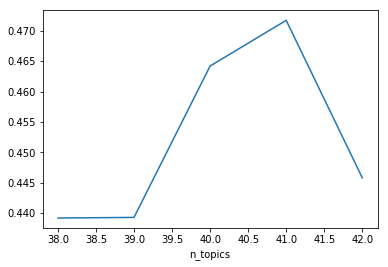

In [123]:
df = pd.DataFrame([ {
    'n_topics': int(model.tm_model.num_topics),
    'perplexity_score': model.perplexity_score,
    'coherence_score': model.coherence_score
  } for model in models ])
df['n_topics'] = df.n_topics.astype(int)
df = df.set_index('n_topics')
df['coherence_score'].plot.line()

### <span style='color: green;'>MODEL</span> Store or Load a Topic Model<span style='color: red; float: right'>OPTIONAL</span>

In [6]:
import pickle
import topic_model
import topic_model_utility

def get_persisted_model_paths():
    return sorted([ x for x in glob.glob(os.path.join(DATA_FOLDER, '*.pickle')) ])

def load_model(gui, model_container, *args):
    
    gui.output.clear_output()
    
    with gui.output:
       
        if gui.stored_path.value is None:
            print("Please specify which model to load.")
            return

        model_container.model = topic_model.load_model(gui.stored_path.value)
    
        topics = topic_model_utility.get_lda_topics(model_container.model.tm_model, n_tokens=20)
        
        display(topics)
        
        print('Model was loaded!')
        
def store_model(gui, model_container, *args):
    
    gui.output.clear_output()
    
    with gui.output:
        if gui.identifier.value == '':
            print("Please specify a unique identifier for the model.")
            return

        if gui.identifier.value != utility.filename_whitelist(gui.identifier.value):
            print("Please use ONLY valid filename characters in identifier.")
            return

        filename = os.path.join(DATA_FOLDER, 'topic_model.pickle')
        filename = utility.path_add_date(filename)
        filename = utility.path_add_suffix(filename, gui.identifier.value)

        topic_model.store_model(model_container.model, filename)

        gui.stored_path.options = get_persisted_model_paths()
        gui.stored_path.value = filename if filename in gui.stored_path.options else None
        
        print('Model stored in file {}'.format(filename))
    
def display_persist_topic_model_gui(model_container):
    
    gui = types.SimpleNamespace(
        stored_path=widgets.Dropdown(description='Path', options=get_persisted_model_paths(), layout=widgets.Layout(width='40%')),
        load=widgets.Button(description='Load', button_style='Success', layout=widgets.Layout(width='80px')),
        store=widgets.Button(description='Store', button_style='Success', layout=widgets.Layout(width='80px')),
        identifier=widgets.Text(description='Identifier', layout=widgets.Layout(width='300px')),
        output=widgets.Output()
    )
    
    boxes = widgets.VBox([
        widgets.HBox([gui.stored_path, gui.load, gui.store, gui.identifier ]),
        widgets.HBox([
            widgets.Label(value="", layout=widgets.Layout(width='40%')),
            widgets.Label(value="Stored models will be named ./data/topic_model_yyyymmdd_$identifier$.pickle", layout=widgets.Layout(width='40%')),
        ]),
        widgets.VBox([gui.output])
    ])
    
    fx = lambda *args: load_model(gui, model_container, *args)
    gui.load.on_click(fx)

    fy = lambda *args: store_model(gui, model_container, *args)
    gui.store.on_click(fy)
    
    display(boxes)

if 'TM_GUI_MODEL' not in globals():
    TM_GUI_MODEL = types.SimpleNamespace(
        model=None
    )
    
display_persist_topic_model_gui(TM_GUI_MODEL)


## <span style='color: green;'>VISUALIZE</span> Display Topic's Word Distribution as a Wordcloud<span style='color: red; float: right'>TRY IT</span>

In [13]:
# Display LDA topic's token wordcloud
opts = { 'max_font_size': 100, 'background_color': 'white', 'width': 900, 'height': 600 }
import wordcloud
import matplotlib.pyplot as plt

def display_wordcloud_gui(callback, tm_data, text_id, output_options=None, word_count=(1, 100, 50)):
    model = tm_data.tm_model
    output_options = output_options or []
    wf = widgets_utility.wf
    wc = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id=text_id,
        text=wf.create_text_widget(text_id),
        topic_id=widgets.IntSlider(
            description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0, continuous_update=False),
        word_count=widgets.IntSlider(
            description='#Words', min=word_count[0], max=word_count[1], step=1, value=word_count[2], continuous_update=False),
        output_format=wf.create_select_widget('Format', output_options, default=output_options[0], layout=widgets.Layout(width="200px")),
        progress = widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))
    )

    wc.prev_topic_id = wc.create_prev_id_button('topic_id', model.num_topics)
    wc.next_topic_id = wc.create_next_id_button('topic_id', model.num_topics)

    iw = widgets.interactive(
        callback,
        tm_data=widgets.fixed(tm_data),
        topic_id=wc.topic_id,
        n_words=wc.word_count,
        output_format=wc.output_format,
        widget_container=widgets.fixed(wc)
    )

    display(widgets.VBox([
        wc.text,
        widgets.HBox([wc.prev_topic_id, wc.next_topic_id, wc.topic_id, wc.word_count, wc.output_format]),
        wc.progress,
        iw.children[-1]
    ]))

    iw.update()

def plot_wordcloud(df_data, token='token', weight='weight', figsize=(14, 14/1.618), **args):
    token_weights = dict({ tuple(x) for x in df_data[[token, weight]].values })
    image = wordcloud.WordCloud(**args,)
    image.fit_words(token_weights)
    plt.figure(figsize=figsize) #, dpi=100)
    plt.imshow(image, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def display_wordcloud(
    tm_data,
    topic_id=0,
    n_words=100,
    output_format='Wordcloud',
    widget_container=None
):
    container = tm_data.compiled_data
    widget_container.progress.value = 1
    df_temp = container.topic_token_weights.loc[(container.topic_token_weights.topic_id == topic_id)]
    tokens = topic_model_utility.get_topic_title(container.topic_token_weights, topic_id, n_words=n_words)
    widget_container.value = 2
    widget_container.text.value = 'ID {}: {}'.format(topic_id, tokens)
    if output_format == 'Wordcloud':
        plot_wordcloud(df_temp, 'token', 'weight', max_words=n_words, **opts)
    elif output_format == 'Table':
        widget_container.progress.value = 3
        df_temp = topic_model_utility.get_topic_tokens(container.topic_token_weights, topic_id=topic_id, n_words=n_words)
        widget_container.progress.value = 4
        display(HTML(df_temp.to_html()))
    widget_container.progress.value = 0

try:
    tm_data = get_current_model()
    display_wordcloud_gui(display_wordcloud, tm_data, 'tx02', ['Wordcloud', 'Table'])
except TopicModelNotComputed as ex:
    logger.info(ex)
    

## <span style='color: green;'>VISUALIZE</span> Display Topic's Word Distribution as a Chart<span style='color: red; float: right'>TRY IT</span>


In [123]:
# Display topic's word distribution
import numpy as np

def plot_topic_word_distribution(tokens, **args):

    source = bokeh.models.ColumnDataSource(tokens)

    p = bokeh.plotting.figure(toolbar_location="right", **args)

    cr = p.circle(x='xs', y='ys', source=source)

    label_style = dict(level='overlay', text_font_size='8pt', angle=np.pi/6.0)

    text_aligns = ['left', 'right']
    for i in [0, 1]:
        label_source = bokeh.models.ColumnDataSource(tokens.iloc[i::2])
        labels = bokeh.models.LabelSet(x='xs', y='ys', text_align=text_aligns[i], text='token', text_baseline='middle',
                          y_offset=5*(1 if i == 0 else -1),
                          x_offset=5*(1 if i == 0 else -1),
                          source=label_source, **label_style)
        p.add_layout(labels)

    p.xaxis[0].axis_label = 'Token #'
    p.yaxis[0].axis_label = 'Probability%'
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "6pt"
    p.axis.major_label_standoff = 0
    return p

def display_topic_tokens(tm_data, topic_id=0, n_words=100, output_format='Chart', widget_container=None):
    widget_container.forward()
    container = tm_data.compiled_data
    tokens = topic_model_utility.get_topic_tokens(container.topic_token_weights, topic_id=topic_id).\
        copy()\
        .drop('topic_id', axis=1)\
        .assign(weight=lambda x: 100.0 * x.weight)\
        .sort_values('weight', axis=0, ascending=False)\
        .reset_index()\
        .head(n_words)
    if output_format == 'Chart':
        widget_container.forward()
        tokens = tokens.assign(xs=tokens.index, ys=tokens.weight)
        p = plot_topic_word_distribution(tokens, plot_width=1000, plot_height=500, title='', tools='box_zoom,wheel_zoom,pan,reset')
        bokeh.plotting.show(p)
        widget_container.forward()
    elif output_format == 'Table':
        #display(tokens)
        display(tokens)
    else:
        display(pivot_ui(tokens))
        
    # Added code for missing method: widget_container.reset()
    if 'progress' in widget_container.__dict__.keys():
        widget_container.progress.value = 0
    
    
def display_topic_distribution_widgets(callback, tm_data, text_id, output_options=None, word_count=(1, 100, 50)):
    
    output_options = output_options or []
    model = tm_data.tm_model
    wf = widgets_utility.wf
    wc = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id=text_id,
        text=wf.create_text_widget(text_id),
        topic_id=widgets.IntSlider(description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0),
        word_count=widgets.IntSlider(description='#Words', min=word_count[0], max=word_count[1], step=1, value=word_count[2]),
        output_format=wf.create_select_widget('Format', output_options, default=output_options[0], layout=widgets.Layout(width="200px")),
        progress=widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))
    )

    wc.prev_topic_id = wc.create_prev_id_button('topic_id', model.num_topics)
    wc.next_topic_id = wc.create_next_id_button('topic_id', model.num_topics)

    iw = widgets.interactive(
        callback,
        tm_data=widgets.fixed(tm_data),
        topic_id=wc.topic_id,
        n_words=wc.word_count,
        output_format=wc.output_format,
        widget_container=widgets.fixed(wc)
    )

    display(widgets.VBox([
        wc.text,
        widgets.HBox([wc.prev_topic_id, wc.next_topic_id, wc.topic_id, wc.word_count, wc.output_format]),
        wc.progress,
        iw.children[-1]
    ]))

    iw.update()

display_topic_distribution_widgets(display_topic_tokens, get_current_model(), 'wc01', ['Chart', 'Table'])

## <span style='color: green;'>VISUALIZE</span> Display Topic's Trend Over Time or Documents<span style='color: red; float: right'>RUN</span>
- Displays topic's share over documents.

- BUGG? Values > 1.0

In [16]:
# Plot a topic's yearly weight over time in selected LDA topic model
import math

def plot_topic_trend(df, category_column, value_column, x_label=None, y_label=None, **figopts):
    
    xs = df[category_column].astype(np.str)
    ys = df[value_column]
    
    figopts = utility.extend(dict(title='', toolbar_location="right"), figopts)
    
    p = bokeh.plotting.figure(**figopts)

    glyph = p.vbar(x=xs, top=ys, width=0.5, fill_color="#b3de69")
    
    p.xaxis.major_label_orientation = math.pi/4
    p.xgrid.grid_line_color = None
    p.xaxis[0].axis_label = (x_label or category_column.title().replace('_', ' ')).title()
    p.yaxis[0].axis_label = (y_label or value_column.title().replace('_', ' ')).title()
    p.y_range.start = 0.0
    p.x_range.range_padding = 0.01
    
    return p

def display_topic_trend(
    topic_id,
    year,
    year_aggregate,
    gui,
    output_format='Chart',
    document_topic_weights=None,
    topic_token_weights=None,
    threshold=0.01
):
    figopts = dict(plot_width=1000, plot_height=700, title='', toolbar_location="right")

    tokens = topic_model_utility.get_topic_title(topic_token_weights, topic_id, n_words=200)
    gui.text.value = 'ID {}: {}'.format(topic_id, tokens)
    
    pivot_column = 'signed_year' if year is None else None
    value_column = year_aggregate if year is None else 'weight'

    df = document_topic_weights[(document_topic_weights.topic_id == topic_id)]
    
    if year is not None:
        df = df[(df.signed_year == year)]
        
    df = df[(df.weight > threshold)].reset_index()
    
    if pivot_column is not None:
        df = df.groupby([pivot_column, 'topic_id']).agg([np.mean, np.max])['weight'].reset_index()
        df.columns = [pivot_column, 'topic_id', 'mean', 'max']
        category_column = pivot_column
        min_year = document_topic_weights.signed_year.min()
        max_year = document_topic_weights.signed_year.max()
        figopts['x_range'] = list(map(str, range(min_year, max_year+1))) # utility.complete_value_range(df[category_column].unique(), str)
    else:
        df['treaty'] = df.treaty_id + ' ' + df.party1 + ' ' + df.party2
        category_column = 'treaty'
        figopts['x_range'] = df['treaty'].unique()
        
    if output_format == 'Table':
        display(df)
    else:
        p = plot_topic_trend(df, category_column, value_column, **figopts)
        bokeh.plotting.show(p)

def create_topic_trend_widgets(tm_data):
    
    model = tm_data.tm_model
    model_data = tm_data.compiled_data
    document_topic_weights = tm_data.compiled_data.document_topic_weights
    topic_token_weights = tm_data.compiled_data.topic_token_weights

    year_options = [ ('all years', None) ] + [ (x,x) for x in range(model_data.year_period[0], model_data.year_period[1] + 1)]
    
    element_id = 'topic_share_plot'
    gui = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id=element_id,
        text=widgets_config.text(dom_id=element_id),
        year=widgets.Dropdown(description='Year', options=year_options, value=None),
        year_aggregate=widgets.Dropdown(description='Aggregate', options=['mean', 'max'], value='max'),
        threshold=widgets.FloatSlider(description='Threshold', min=0.0, max=0.25, step=0.01, value=0.10, continuous_update=False),
        topic_id=widgets.IntSlider(description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0, continuous_update=False),
        output_format=widgets.Dropdown(description='Format', options=['Chart', 'Table'], value='Chart'),
        progress=widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="50%")),
    )
    
    gui.prev_topic_id = gui.create_prev_id_button('topic_id', model.num_topics)
    gui.next_topic_id = gui.create_next_id_button('topic_id', model.num_topics)
    
    iw = widgets.interactive(
        display_topic_trend,
        topic_id=gui.topic_id,
        year=gui.year,
        year_aggregate=gui.year_aggregate,
        gui=widgets.fixed(gui),
        output_format=gui.output_format,
        document_topic_weights=widgets.fixed(model_data.document_topic_weights),
        topic_token_weights=widgets.fixed(model_data.topic_token_weights),
        threshold=gui.threshold
    )

    display(widgets.VBox([
        gui.text,
        widgets.HBox([gui.prev_topic_id, gui.next_topic_id, gui.year, gui.year_aggregate, gui.output_format]),
        widgets.HBox([gui.topic_id, gui.threshold, gui.progress]),
        iw.children[-1]
    ]))
    
    iw.update()

tm_data = get_current_model()
create_topic_trend_widgets(tm_data)

## <span style='color: green;'>VISUALIZE</span> Display Topic to Document Network<span style='color: red; float: right'>TRY IT</span>
The green nodes are documents, and blue nodes are topics. The edges (lines) indicates the strength of a topic in the connected document. The width of the edge is proportinal to the strength of the connection. Note that only edges with a strength above the certain threshold are displayed.

In [18]:
# Visualize year-to-topic network by means of topic-document-weights
from common.plot_utility import layout_algorithms, PlotNetworkUtility
from common.network_utility import NetworkUtility, DISTANCE_METRICS, NetworkMetricHelper

def plot_document_topic_network(network, layout, scale=1.0, titles=None):
    tools = "pan,wheel_zoom,box_zoom,reset,hover,previewsave"
    year_nodes, topic_nodes = NetworkUtility.get_bipartite_node_set(network, bipartite=0)  
    
    year_source = NetworkUtility.get_node_subset_source(network, layout, year_nodes)
    topic_source = NetworkUtility.get_node_subset_source(network, layout, topic_nodes)
    lines_source = NetworkUtility.get_edges_source(network, layout, scale=6.0, normalize=False)
    
    edges_alphas = NetworkMetricHelper.compute_alpha_vector(lines_source.data['weights'])
    
    lines_source.add(edges_alphas, 'alphas')
    
    p = bokeh.plotting.figure(plot_width=1000, plot_height=600, x_axis_type=None, y_axis_type=None, tools=tools)
    
    r_lines = p.multi_line(
        'xs', 'ys', line_width='weights', alpha='alphas', color='black', source=lines_source
    )
    r_years = p.circle(
        'x','y', size=40, source=year_source, color='lightgreen', level='overlay', line_width=1,alpha=1.0
    )
    
    r_topics = p.circle('x','y', size=25, source=topic_source, color='skyblue', level='overlay', alpha=1.00)
    
    p.add_tools(bokeh.models.HoverTool(renderers=[r_topics], tooltips=None, callback=widgets_utility.wf.\
        glyph_hover_callback(topic_source, 'node_id', text_ids=titles.index, text=titles, element_id='nx_id1'))
    )

    text_opts = dict(x='x', y='y', text='name', level='overlay', x_offset=0, y_offset=0, text_font_size='8pt')
    
    p.add_layout(
        bokeh.models.LabelSet(
            source=year_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    p.add_layout(
        bokeh.models.LabelSet(
            source=topic_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    
    return p
        
def display_document_topic_network(layout_algorithm, tm_data, threshold=0.10, parties=None, period=None, ignores=None, scale=1.0, output_format='network', tick=utility.noop):

    tick(1)
    
    container = tm_data.compiled_data
    
    titles = topic_model_utility.get_topic_titles(container.topic_token_weights)

    df = container.document_topic_weights[container.document_topic_weights.weight > threshold].reset_index()

    if len(parties or []) > 0:
        df = df[df.party1.isin(parties) | df.party2.isin(parties)]

    if len(period or []) == 2:
        df = df[(df.signed_year>=period[0]) & (df.signed_year<=period[1])]
        
    if len(ignores or []) > 0:
        df = df[~df.topic_id.isin(ignores)]

    if len(df) == 0:
        print('No data')
        return
    
    df['title'] = df.treaty_id + ' ' + df.party1 + ' ' + df.party2

    network = NetworkUtility.create_bipartite_network(df, 'title', 'topic_id')
    tick()

    if output_format == 'network':
        args = PlotNetworkUtility.layout_args(layout_algorithm, network, scale)
        layout = (layout_algorithms[layout_algorithm])(network, **args)
        tick()
        p = plot_document_topic_network(network, layout, scale=scale, titles=titles)
        bokeh.plotting.show(p)

    elif output_format == 'table':
        display(df)

    tick(0)
        
def document_topic_network_gui(wti_index, tm_data):
    
    lw = lambda w: widgets.Layout(width=w)
    
    model = tm_data.tm_model
    text_id = 'nx_id1'
    layout_options = [ 'Circular', 'Kamada-Kawai', 'Fruchterman-Reingold']
    party_preset_options = wti_index.get_party_preset_options()
    parties_options = [ x for x in wti_index.get_countries_list() if x != 'ALL OTHER' ]
    year_min, year_max = tm_data.compiled_data.year_period
    
    n_topics = tm_data.tm_model.num_topics
    
    gui = types.SimpleNamespace(
        text=widgets_utility.wf.create_text_widget(text_id),
        period=widgets.IntRangeSlider(description='Time', min=year_min, max=year_max, step=1, value=(year_min, year_max), continues_update=False),
        scale=widgets.FloatSlider(description='Scale', min=0.0, max=1.0, step=0.01, value=0.1, continues_update=False),
        threshold=widgets.FloatSlider(description='Threshold', min=0.0, max=1.0, step=0.01, value=0.50, continues_update=False),
        output_format=widgets_utility.dropdown('Output', { 'Network': 'network', 'Table': 'table' }, 'network', layout=lw('200px')),
        layout=widgets_utility.dropdown('Layout', layout_options, 'Fruchterman-Reingold', layout=lw('250px')),
        parties=widgets.SelectMultiple(description='Parties', options=parties_options, value=[], rows=7, layout=lw('180px')),
        party_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('180px')),
        progress=widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="99%")),
        ignores=widgets.SelectMultiple(description='Ignore', options=[('', None)] + [ ('Topic #'+str(i), i) for i in range(0, n_topics) ], value=[], rows=8, layout=lw('180px')),
    )
    
    def tick(x=None):
        gui.progress.value = gui.progress.value + 1 if x is None else x
        
    def on_party_preset_change(change):  # pylint: disable=W0613
        if gui.party_preset.value is None:
            return
        gui.parties.value = gui.parties.options if 'ALL' in gui.party_preset.value else gui.party_preset.value
            
    gui.party_preset.observe(on_party_preset_change, names='value')
    
    iw = widgets.interactive(
        display_document_topic_network,
        layout_algorithm=gui.layout,
        tm_data=widgets.fixed(tm_data),
        threshold=gui.threshold,
        parties=gui.parties,
        period=gui.period,
        ignores=gui.ignores,
        scale=gui.scale,
        output_format=gui.output_format,
        tick=widgets.fixed(tick)
    )

    display(widgets.VBox([
        gui.text,
        widgets.HBox([
            widgets.VBox([gui.layout, gui.threshold, gui.scale, gui.period]), 
            widgets.VBox([gui.parties, gui.party_preset]), 
            widgets.VBox([gui.ignores]), 
            widgets.VBox([gui.output_format, gui.progress]),
        ]),
        iw.children[-1]
    ]))
    iw.update()

try:
    tm_data = get_current_model()
    document_topic_network_gui(WTI_INDEX, tm_data)
except Exception as ex:
    logger.error(ex)
    

## <span style='color: green;'>VISUALIZE</span> Topic Trends Overview<span style='color: red; float: right'>TRY IT</span>

- The topic shares  displayed as a scattered heatmap plot using gradient color based on topic's weight in document.
- [Stanford’s Termite software](http://vis.stanford.edu/papers/termite) uses a similar visualization.

In [19]:
# plot_topic_relevance_by_year
import bokeh.transform

def isint(s):
    try:
        int(s)
        return True
    except:
        return False
    
def get_topic_weight_by_year_or_document(document_topic_weights, key='mean', year=None):
    pivot_column = 'year' if year is None else 'document_id'
    #if df[(df.year == year)]
    df = self.get_document_topic_weights(year) \
        .groupby([pivot_column,'topic_id']) \
        .agg(config.AGGREGATES[key])[['weight']].reset_index()
    return df, pivot_column
    
def setup_glyph_coloring(df):
    max_weight = df.weight.max()
    #colors = list(reversed(bokeh.palettes.Greens[9]))
    colors = ['#ffffff', '#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
    mapper = bokeh.models.LinearColorMapper(palette=colors, low=0.0, high=1.0) # low=df.weight.min(), high=max_weight)
    color_transform = bokeh.transform.transform('weight', mapper)
    color_bar = bokeh.models.ColorBar(color_mapper=mapper, location=(0, 0),
                         ticker=bokeh.models.BasicTicker(desired_num_ticks=len(colors)),
                         formatter=bokeh.models.PrintfTickFormatter(format=" %5.2f"))
    return color_transform, color_bar

def compute_int_range_categories(values):
    categories = values.unique()
    if all(map(utility.isint, categories)):
        categories = sorted(list(map(int, categories)))
        return list(map(str, categories))
    else:
        return sorted(list(categories))

HEATMAP_FIGOPTS = dict(title="Topic heatmap", toolbar_location="right",  x_axis_location="above", plot_width=1000)

def plot_topic_relevance_by_year(df, xs, ys, flip_axis, titles, text_id, **figopts):

    line_height = 7
    if flip_axis is True:
        xs, ys = ys, xs
        line_height = 10

    x_range = compute_int_range_categories(df[xs])
    y_range = compute_int_range_categories(df[ys])
    
    color_transform, color_bar = setup_glyph_coloring(df)
    
    source = bokeh.models.ColumnDataSource(df)

    if x_range is not None:
        figopts['x_range'] = x_range

    if y_range is not None:
        figopts['y_range'] = y_range
        figopts['plot_height'] = max(len(y_range) * line_height, 500)
    
    p = bokeh.plotting.figure(**figopts)

    args = dict(x=xs, y=ys, source=source, alpha=1.0, hover_color='red')
    
    cr = p.rect(width=1, height=1, line_color=None, fill_color=color_transform, **args)

    p.x_range.range_padding = 0
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "8pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    p.add_layout(color_bar, 'right')
    
    p.add_tools(bokeh.models.HoverTool(tooltips=None, callback=widgets_utility.WidgetUtility.glyph_hover_callback(
        source, 'topic_id', titles.index, titles, text_id), renderers=[cr]))
    
    return p

def display_doc_topic_heatmap(model_data, key='max', flip_axis=False, glyph='Circle', year=None, year_aggregate=None, output_format=None):
    try:

        titles = topic_model_utility.get_topic_titles(model_data.topic_token_weights, n_words=100)
        
        df = model_data.document_topic_weights.copy()

        if year is not None:
            df = df[(df.signed_year == year)]

        if year is None:
            
            ''' Display aggregate value grouped by year  '''
            df = df.groupby(['signed_year', 'topic_id']).agg([np.mean, np.max])['weight'].reset_index()
            df.columns = ['signed_year', 'topic_id', 'mean', 'max']
            df['weight'] = df[year_aggregate]
            df['signed_year'] = df.signed_year.astype(str)
            category_column = 'signed_year'
            
        else:
            ''' Display individual treaties for selected year  '''
            df['treaty'] = df.treaty_id + ' ' + df.party1 + ' ' + df.party2
            df = df[['treaty', 'treaty_id', 'topic_id', 'weight']]
            category_column = 'treaty'  
        
        df['document_id'] = df.index.astype(str)
        df['topic_id'] = df.topic_id.astype(str)
         
        if output_format.lower() == 'heatmap':
            
            p = plot_topic_relevance_by_year(
                df,
                xs=category_column,
                ys='topic_id',
                flip_axis=flip_axis,
                titles=titles,
                text_id='topic_relevance',
                **HEATMAP_FIGOPTS)

            bokeh.plotting.show(p)
            
        else:
            display(df)
        
    except Exception as ex:
        raise
        logger.error(ex)
        
def doc_topic_heatmap_gui(model_data):

    lw = lambda w: widgets.Layout(width=w)
    
    text_id = 'topic_relevance'
    
    def text_widget(element_id=None, default_value='', style='', line_height='20px'):
        value = "<span class='{}' style='line-height: {};{}'>{}</span>".format(element_id, line_height, style, default_value) if element_id is not None else ''
        return widgets.HTML(value=value, placeholder='', description='', layout=widgets.Layout(height='150px'))
    
    year_options = [ ('all years', None) ] + [ (x,x) for x in range(model_data.year_period[0], model_data.year_period[1] + 1)]
    
    gui = types.SimpleNamespace(
        text_id=text_id,
        text=text_widget(text_id),
        flip_axis=widgets.ToggleButton(value=True, description='Flip', icon='', layout=lw("80px")),
        year=widgets.Dropdown(description='Year', options=year_options, value=None, layout=lw("160px")),
        year_aggregate=widgets.Dropdown(description='Aggregate', options=['mean', 'max'], value='max', layout=lw("160px")),
        output_format=widgets.Dropdown(description='Output', options=['Heatmap', 'Table'], value='Heatmap', layout=lw("180px"))
    )
    
    iw = widgets.interactive(
        display_doc_topic_heatmap,
        model_data=widgets.fixed(model_data),
        flip_axis=gui.flip_axis,
        year=gui.year,
        year_aggregate=gui.year_aggregate,
        output_format=gui.output_format
    )

    display(widgets.VBox([
        widgets.HBox([gui.year, gui.year_aggregate, gui.output_format, gui.flip_axis ]),
        widgets.HBox([iw.children[-1]]), gui.text
    ]))

    iw.update()

try:
    doc_topic_heatmap_gui(get_current_model().compiled_data)
except Exception as ex:
    logger.error(ex)
    

## <span style='color: green;'>VISUALIZE</span> Topic Cooccurrence<span style='color: red; float: right'>TRY IT</span>

Computes weighted graph of topics co-occurring in the same document. Topics are defined as co-occurring if they both exists  in the same document both having weights above threshold. Weight are number of co-occurrences (binary yes or no). Node size reflects topic proportions over the entire corpus (normalized document) length, and are computed in accordance to how node sizes are computed in LDAvis.

In [25]:
# Visualize topic co-occurrence

import common.plot_utility as plot_utility
import common.network_utility as network_utility
import bokeh.plotting # import figure, show, output_notebook, output_file

bokeh.plotting.output_notebook()

def get_topic_titles(topic_token_weights, topic_id=None, n_words=100):
    df_temp = topic_token_weights if topic_id is None else topic_token_weights[(topic_token_weights.topic_id==topic_id)]
    df = df_temp\
            .sort_values('weight', ascending=False)\
            .groupby('topic_id')\
            .apply(lambda x: ' '.join(x.token[:n_words].str.title()))
    return df

# FIXME: add doc token length to df_documents
def get_topic_proportions(corpus_documents, document_topic_weights):
    topic_proportion = topic_model.compute_topic_proportions(document_topic_weights, corpus_documents)
    return topic_proportion
    
def display_topic_co_occurrence_network(
    tm_data,
    parties=None,
    period=None,
    ignores=None,
    threshold=0.10,
    layout='Fruchterman-Reingold',
    scale=1.0,
    output_format='table'
):
    try:
        
        model_data = tm_data.compiled_data
        
        titles = topic_model_utility.get_topic_titles(model_data.topic_token_weights)
        df = model_data.document_topic_weights
        df['document_id'] = df.index
        
        node_sizes = topic_model.compute_topic_proportions(df, model_data.documents)

        if ignores is not None:
            df = df[~df.topic_id.isin(ignores)]
            
        if len(parties or []) > 0:
            df = df[df.party1.isin(parties) | df.party2.isin(parties)]
            
        if period is not None:
            df = df[df.signed_year.between(period[0], period[1], inclusive=True)]
            
        df = df.loc[(df.weight >= threshold)]
        df = pd.merge(df, df, how='inner', left_on='document_id', right_on='document_id')
        df = df.loc[(df.topic_id_x < df.topic_id_y)]
        df = df.groupby([df.topic_id_x, df.topic_id_y]).size().reset_index()
        df.columns = ['source', 'target', 'weight']
        
        if len(df) == 0:
            print('No data. Please change selections.')
            return
        
        if output_format == 'table':
            display(df)
        else:
            network = network_utility.NetworkUtility.create_network(df, source_field='source', target_field='target', weight='weight')
            p = plot_utility.PlotNetworkUtility.plot_network(
                network=network,
                layout_algorithm=layout,
                scale=scale,
                threshold=0.0,
                node_description=titles,
                node_proportions=node_sizes,
                weight_scale=10.0,
                normalize_weights=True,
                element_id='cooc_id',
                figsize=(900,500)
            )
            bokeh.plotting.show(p)

    except Exception as x:
        raise
        print("No data: please adjust filters")

def topic_coocurrence_network_gui(wti_index, tm_data):
    
    lw = lambda w: widgets.Layout(width=w)
    n_topics = tm_data.tm_model.num_topics
    
    model = tm_data.tm_model
    text_id = 'cooc_id'
    layout_options = [ 'Circular', 'Kamada-Kawai', 'Fruchterman-Reingold']
    party_preset_options = wti_index.get_party_preset_options()
    parties_options = [ x for x in wti_index.get_countries_list() if x != 'ALL OTHER' ]
    year_min, year_max = tm_data.compiled_data.year_period
    
    gui = types.SimpleNamespace(
        n_topics=n_topics,
        text=widgets_utility.wf.create_text_widget(text_id),
        period=widgets.IntRangeSlider(description='Time', min=year_min, max=year_max, step=1, value=(year_min, year_max), continues_update=False),
        scale=widgets.FloatSlider(description='Scale', min=0.0, max=1.0, step=0.01, value=0.1, continues_update=False),
        threshold=widgets.FloatSlider(description='Threshold', min=0.0, max=1.0, step=0.01, value=0.20, continues_update=False),
        output_format=widgets_utility.dropdown('Output', { 'Network': 'network', 'Table': 'table' }, 'network', layout=lw('200px')),
        layout=widgets_utility.dropdown('Layout', layout_options, 'Fruchterman-Reingold', layout=lw('250px')),
        parties=widgets.SelectMultiple(description='Parties', options=parties_options, value=[], rows=7, layout=lw('180px')),
        party_preset=widgets_config.dropdown('Presets', party_preset_options, None, layout=lw('180px')),
        progress=widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="99%")),
        ignores=widgets.SelectMultiple(description='Ignore', options=[('', None)] + [ ('Topic #'+str(i), i) for i in range(0, n_topics) ], value=[], rows=8, layout=lw('180px')),
    )
    def tick(x=None):
        gui.progress.value = gui.progress.value + 1 if x is None else x
        
    def on_party_preset_change(change):  # pylint: disable=W0613
        if gui.party_preset.value is None:
            return
        gui.parties.value = gui.parties.options if 'ALL' in gui.party_preset.value else gui.party_preset.value
            
    gui.party_preset.observe(on_party_preset_change, names='value')
     
    iw = widgets.interactive(
        display_topic_co_occurrence_network,
        tm_data=widgets.fixed(tm_data),
        parties=gui.parties,
        period=gui.period,
        ignores=gui.ignores,
        threshold=gui.threshold,
        layout=gui.layout,
        scale=gui.scale,
        output_format=gui.output_format
    )
    display(widgets.VBox([
        gui.text,
        widgets.HBox([
            widgets.VBox([gui.layout, gui.threshold, gui.scale, gui.period]), 
            widgets.VBox([gui.parties, gui.party_preset]), 
            widgets.VBox([gui.ignores]), 
            widgets.VBox([gui.output_format, gui.progress]),
        ]),
        iw.children[-1]
    ]))
    iw.update()
    
try:
    tm_data = get_current_model()
    topic_coocurrence_network_gui(WTI_INDEX, tm_data)
except Exception as ex:
    logger.error(ex)

Loading BokehJS ...